In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from tqdm import tqdm
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}

In [2]:
from sklearn.metrics import *
from scipy.optimize import minimize

# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            score = compute_score(current_thresholds, inferenced_array, exp_name)
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [3]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = mixup(
    #         tomogram, segmentation_map, alpha=mixup_alpha
    #     )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [4]:
from transformers import get_cosine_schedule_with_warmup

In [5]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [6]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor


padf = PadToSize(CFG.resolution)

In [7]:
for vaild_exp_name in CFG.train_exp_names:
    wandb.init(
        project="czii2024", name=f"{notebook_name}_{vaild_exp_name}", config=param
    )

    vaild_exp_name = [vaild_exp_name]
    train_exp_name = CFG.train_exp_names.copy()
    train_exp_name.remove(vaild_exp_name[0])

    # valid_exp_name[0]の名前でディレクトリを作成
    os.makedirs(f"./{vaild_exp_name[0]}", exist_ok=True)

    train_dataset = EziiDataset(
        exp_names=train_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.train_zarr_types,
        train=True,
        augmentation=True,
        slice=True,
        pre_read=True,
    )
    valid_dataset = EziiDataset(
        exp_names=vaild_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.valid_zarr_types,
        augmentation=False,
        train=True,
        slice=True,
        pre_read=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    encoder = timm.create_model(
        model_name=CFG.model_name,
        pretrained=True,
        in_chans=3,
        num_classes=0,
        global_pool="",
        features_only=True,
    )
    model = Unet3D(encoder=encoder, num_domains=5).to("cuda")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
    )
    criterion = DiceLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=10,
        num_training_steps=CFG.epochs * len(train_loader),
        # * batch_size,
    )
    scaler = GradScaler()
    seg_loss = SegmentationLoss(criterion)
    padf = PadToSize(CFG.resolution)

    best_model = None
    best_constant = 0
    best_score = -100
    best_particle_score = {}

    grand_train_loss = []
    grand_valid_loss = []
    grand_train_score = []
    grand_valid_score = []

    for epoch in range(CFG.epochs):
        model.train()
        train_loss = []
        valid_loss = []
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]"
        ) as tq:
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"]
                segmentation_map = data["segmentation_map"]
                zarr_embedding_idx = data["zarr_type_embedding_idx"]

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                # データ拡張
                normalized_tomogram, segmentation_map = augment_data(
                    normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
                )
                normalized_tomogram = normalized_tomogram.cuda()
                segmentation_map = segmentation_map.long().cuda()
                zarr_embedding_idx = zarr_embedding_idx.cuda()

                optimizer.zero_grad()

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                # loss.backward()
                # optimizer.step()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                train_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        with tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]"
        ) as tq:
            with torch.no_grad():
                for data in tq:
                    normalized_tomogram = data["normalized_tomogram"].cuda()
                    segmentation_map = data["segmentation_map"].long().cuda()
                    zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                    normalized_tomogram = padf(normalized_tomogram)
                    segmentation_map = padf(segmentation_map)

                    with autocast():
                        pred = model(
                            preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                        )
                        loss = seg_loss(pred, segmentation_map)
                    valid_loss.append(loss.item())

                    # 確率予測
                    prob_pred = torch.softmax(pred, dim=1)
                    tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        # # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        # モデルの保存
        make_dir_ = (
            f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
        )
        os.makedirs(make_dir_, exist_ok=True)
        torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

        # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        train_inferenced_array = {}
        train_pred_array = []
        train_gt_array = []
        valid_inferenced_array = {}
        valid_gt_array = []

        # for exp_name in tqdm(CFG.train_exp_names):
        for exp_name in vaild_exp_name:  # 5つのデータで試す
            # inferenced_array = inference(model, exp_name, train=False)
            inferenced_array, n_tomogram, segmentation_map = inference(
                model, exp_name, train=False
            )
            valid_inferenced_array[exp_name] = inferenced_array
            base_dir = "../../inputs/train/overlay/ExperimentRuns/"
            gt_df = create_gt_df(base_dir, [exp_name])
            valid_gt_array.append(gt_df)

        valid_gt_array = pd.concat(valid_gt_array)

        b_constant = 0
        b_score = -100
        b_particle_score = {}

        try:
            best_thresholds, final_score = reduce_computation_sikii_search(
                inferenced_array,
                exp_name,
                [
                    0.05,
                    0.1,
                    0.15,
                    0.2,
                    0.25,
                    0.3,
                    0.35,
                    0.4,
                    0.45,
                    0.5,
                    0.55,
                    0.6,
                    0.65,
                    0.7,
                    0.75,
                ],
            )
        except:
            best_thresholds = [0.5] * 6
            final_score = -50

        b_score = final_score
        b_particle_constant = {
            "apo-ferritin": best_thresholds[0],
            "beta-amylase": best_thresholds[1],
            "beta-galactosidase": best_thresholds[2],
            "ribosome": best_thresholds[3],
            "thyroglobulin": best_thresholds[4],
            "virus-like-particle": best_thresholds[5],
        }

        try:
            valid_pred_array = []
            for exp_name in [vaild_exp_name[0]]:
                pred_df = inference2pos(
                    pred_segmask=valid_inferenced_array[exp_name],
                    exp_name=exp_name,
                    sikii_dict=b_particle_constant,
                )
                valid_pred_array.append(pred_df)

            valid_pred_array = pd.concat(valid_pred_array)

            if len(valid_pred_array) != 0:
                result_df, score_ = compute_lb(
                    valid_pred_array,
                    "../../inputs/train/overlay/ExperimentRuns/",
                    vaild_exp_name,
                )
                particle_score = extract_particle_results(result_df)

                b_score = score_
                b_particle_score = particle_score
        except:
            b_score = -50
            b_particle_score = {}

        import gc
        import torch.cuda as cuda

        # del valid_pred_array, valid_gt_array
        gc.collect()
        cuda.empty_cache()

        # print("constant", b_constant, "score", b_score)

        # wandb-log
        train_info = {
            "01_epoch": epoch,
            "02_train_loss": np.mean(train_loss),
            "03_valid_loss": np.mean(valid_loss),
            # "train_score": np.mean(train_mean_scores),
            "04_valid_best_score": b_score,
        }
        train_info = {**train_info, **b_particle_score}
        train_info = {**train_info, **b_particle_constant}
        wandb.log(train_info)

        # score-update
        if b_score > best_score:
            best_score = b_score
            # best_score = np.mean(valid_mean_scores)
            best_model = model.state_dict()
            torch.save(best_model, f"./{vaild_exp_name[0]}/best_model.pth")

        print(
            f"train-epoch-loss:{np.mean(train_loss):.4f}",
            # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
            # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
            f"valid-beta4-score:{b_score:.4f}",
        )

        grand_train_loss.append(np.mean(train_loss))
        # grand_valid_loss.append(np.mean(valid_loss))
        # grand_train_score.append(np.mean(train_mean_scores))
        grand_valid_score.append(b_score)

    del model, optimizer, criterion, scheduler, scaler, seg_loss
    gc.collect()
    torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tatuya (latent-walkers). Use `wandb login --relogin` to force relogin


  0%|          | 0/6 [00:12<?, ?it/s]


train-epoch-loss:0.9092 valid-beta4-score:-50.0000


100%|██████████| 6/6 [03:29<00:00, 34.93s/it]


train-epoch-loss:0.8630 valid-beta4-score:0.2333


100%|██████████| 6/6 [03:23<00:00, 33.96s/it]


train-epoch-loss:0.8296 valid-beta4-score:0.3801


100%|██████████| 6/6 [03:28<00:00, 34.82s/it]


train-epoch-loss:0.8136 valid-beta4-score:0.4442


100%|██████████| 6/6 [03:30<00:00, 35.11s/it]


train-epoch-loss:0.7950 valid-beta4-score:0.4278


100%|██████████| 6/6 [03:26<00:00, 34.44s/it]


train-epoch-loss:0.7754 valid-beta4-score:0.5259


100%|██████████| 6/6 [03:25<00:00, 34.21s/it]


train-epoch-loss:0.7498 valid-beta4-score:0.5808


100%|██████████| 6/6 [03:27<00:00, 34.56s/it]


train-epoch-loss:0.7504 valid-beta4-score:0.5282


100%|██████████| 6/6 [03:32<00:00, 35.36s/it]


train-epoch-loss:0.7306 valid-beta4-score:0.5717


100%|██████████| 6/6 [03:29<00:00, 34.85s/it]


train-epoch-loss:0.7233 valid-beta4-score:0.5840


100%|██████████| 6/6 [03:28<00:00, 34.70s/it]


train-epoch-loss:0.7153 valid-beta4-score:0.6575


100%|██████████| 6/6 [03:27<00:00, 34.57s/it]


train-epoch-loss:0.7249 valid-beta4-score:0.6666


100%|██████████| 6/6 [03:29<00:00, 34.86s/it]


train-epoch-loss:0.7191 valid-beta4-score:0.6154


100%|██████████| 6/6 [03:30<00:00, 35.17s/it]


train-epoch-loss:0.7181 valid-beta4-score:0.6340


100%|██████████| 6/6 [03:39<00:00, 36.51s/it]


train-epoch-loss:0.7129 valid-beta4-score:0.6854


100%|██████████| 6/6 [03:30<00:00, 35.16s/it]


train-epoch-loss:0.7130 valid-beta4-score:0.6648


100%|██████████| 6/6 [03:30<00:00, 35.14s/it]


train-epoch-loss:0.6859 valid-beta4-score:0.7211


100%|██████████| 6/6 [03:31<00:00, 35.17s/it]


train-epoch-loss:0.7108 valid-beta4-score:0.6739


100%|██████████| 6/6 [03:29<00:00, 34.89s/it]


train-epoch-loss:0.6874 valid-beta4-score:0.7630


100%|██████████| 6/6 [03:29<00:00, 34.98s/it]


train-epoch-loss:0.6967 valid-beta4-score:0.7427


100%|██████████| 6/6 [03:30<00:00, 35.02s/it]


train-epoch-loss:0.6984 valid-beta4-score:0.7773


100%|██████████| 6/6 [03:30<00:00, 35.01s/it]


train-epoch-loss:0.6757 valid-beta4-score:0.7867


100%|██████████| 6/6 [03:29<00:00, 34.94s/it]


train-epoch-loss:0.7053 valid-beta4-score:0.7802


100%|██████████| 6/6 [03:30<00:00, 35.06s/it]


train-epoch-loss:0.6990 valid-beta4-score:0.7800


100%|██████████| 6/6 [03:30<00:00, 35.08s/it]


train-epoch-loss:0.6871 valid-beta4-score:0.7958


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
02_train_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁
03_valid_loss,█▇▇▆▆▃▆▂▃▃▂▂█▄█▁▁▂▅▂▄▂▃▄█
04_valid_best_score,▁████████████████████████
apo-ferritin,▅▃▂▁▁▄██▇▇▅██████▆█▇█▇██▇
apoo_ferritin_f4,▂▁▂▂▆█▇▇▆▇█▇▆▇▆▆▇▇▇▆▇▇▇▇
apoo_ferritin_p,▁▁▁▁▇█▆█▆▇█▇▆█▆▆▇▇▇▇▇█▇▇
apoo_ferritin_r,▂▁▂▃▅▇▇▇▆██▇▆▇▆▆▆▇▇▆▇▇▆▇
beta-amylase,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▅▁▁▁▁▁▁▁▁▁▂▁▂▁█▅▇▅▇▅▄▅▅▇▄
beta_amylase_f4,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [03:45<00:00, 37.64s/it]


train-epoch-loss:0.9107 valid-beta4-score:0.3500


100%|██████████| 6/6 [03:41<00:00, 36.95s/it]


train-epoch-loss:0.8591 valid-beta4-score:0.2732


100%|██████████| 6/6 [03:26<00:00, 34.45s/it]


train-epoch-loss:0.8328 valid-beta4-score:0.2635


100%|██████████| 6/6 [03:22<00:00, 33.76s/it]


train-epoch-loss:0.8251 valid-beta4-score:0.3992


100%|██████████| 6/6 [03:24<00:00, 34.02s/it]


train-epoch-loss:0.8113 valid-beta4-score:0.4639


100%|██████████| 6/6 [03:22<00:00, 33.72s/it]


train-epoch-loss:0.8043 valid-beta4-score:0.5434


100%|██████████| 6/6 [03:30<00:00, 35.02s/it]


train-epoch-loss:0.7963 valid-beta4-score:0.4387


100%|██████████| 6/6 [03:25<00:00, 34.29s/it]


train-epoch-loss:0.7877 valid-beta4-score:0.5210


100%|██████████| 6/6 [03:25<00:00, 34.32s/it]


train-epoch-loss:0.7824 valid-beta4-score:0.5307


100%|██████████| 6/6 [03:26<00:00, 34.40s/it]


train-epoch-loss:0.7751 valid-beta4-score:0.5167


100%|██████████| 6/6 [03:24<00:00, 34.15s/it]


train-epoch-loss:0.7861 valid-beta4-score:0.4955


100%|██████████| 6/6 [03:27<00:00, 34.51s/it]


train-epoch-loss:0.7730 valid-beta4-score:0.5226


100%|██████████| 6/6 [03:26<00:00, 34.39s/it]


train-epoch-loss:0.7740 valid-beta4-score:0.5298


100%|██████████| 6/6 [03:26<00:00, 34.41s/it]


train-epoch-loss:0.7735 valid-beta4-score:0.5284


100%|██████████| 6/6 [03:26<00:00, 34.39s/it]


train-epoch-loss:0.7656 valid-beta4-score:0.5555


100%|██████████| 6/6 [03:26<00:00, 34.38s/it]


train-epoch-loss:0.7555 valid-beta4-score:0.5286


100%|██████████| 6/6 [03:26<00:00, 34.45s/it]


train-epoch-loss:0.7586 valid-beta4-score:0.5743


100%|██████████| 6/6 [03:24<00:00, 34.15s/it]


train-epoch-loss:0.7595 valid-beta4-score:0.5811


100%|██████████| 6/6 [03:22<00:00, 33.78s/it]


train-epoch-loss:0.7495 valid-beta4-score:0.5581


100%|██████████| 6/6 [03:22<00:00, 33.82s/it]


train-epoch-loss:0.7340 valid-beta4-score:0.5811


100%|██████████| 6/6 [03:23<00:00, 33.86s/it]


train-epoch-loss:0.7266 valid-beta4-score:0.5762


100%|██████████| 6/6 [03:23<00:00, 33.84s/it]


train-epoch-loss:0.7341 valid-beta4-score:0.5840


100%|██████████| 6/6 [03:23<00:00, 33.93s/it]


train-epoch-loss:0.7342 valid-beta4-score:0.5814


100%|██████████| 6/6 [03:23<00:00, 33.97s/it]


train-epoch-loss:0.7382 valid-beta4-score:0.5825


100%|██████████| 6/6 [03:23<00:00, 33.89s/it]


train-epoch-loss:0.7428 valid-beta4-score:0.5843


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
02_train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▂
03_valid_loss,█▆▆▆▅▇▅▅▄▄▅▃▅▃█▃▄▄▆▃▅▂▁█▂
04_valid_best_score,▃▁▁▄▅▇▅▇▇▇▆▇▇▇▇▇██▇██████
apo-ferritin,▁▁▁▂▃▃▃▂▄▄▄▅▅▄▅▅▅▆▇▇█▇██▇
apoo_ferritin_f4,▁▁▁▂▅▆▄▅▅▅█▆▆▅█▅▆▆▆▇▇▇▇▇▇
apoo_ferritin_p,▁▁▁▁▂▃▃▅▅▅█▆▆▄▇▅▇▆▅█▇▇▇▇█
apoo_ferritin_r,▂▁▁▄▅▆▃▅▅▅█▆▆▅█▅▆▆▆▆▆▆▆▆▆
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_amylase_f4,▇▂▁▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [03:44<00:00, 37.41s/it]


train-epoch-loss:0.9163 valid-beta4-score:0.1676


100%|██████████| 6/6 [04:02<00:00, 40.48s/it]


train-epoch-loss:0.8700 valid-beta4-score:0.0857


100%|██████████| 6/6 [03:36<00:00, 36.10s/it]


train-epoch-loss:0.8356 valid-beta4-score:0.3556


100%|██████████| 6/6 [03:31<00:00, 35.23s/it]


train-epoch-loss:0.7970 valid-beta4-score:0.3007


100%|██████████| 6/6 [03:26<00:00, 34.38s/it]


train-epoch-loss:0.7691 valid-beta4-score:0.4724


100%|██████████| 6/6 [03:27<00:00, 34.64s/it]


train-epoch-loss:0.7811 valid-beta4-score:0.4631


100%|██████████| 6/6 [03:28<00:00, 34.81s/it]


train-epoch-loss:0.7724 valid-beta4-score:0.4686


100%|██████████| 6/6 [03:30<00:00, 35.02s/it]


train-epoch-loss:0.7626 valid-beta4-score:0.4822


100%|██████████| 6/6 [03:30<00:00, 35.09s/it]


train-epoch-loss:0.7615 valid-beta4-score:0.4980


100%|██████████| 6/6 [03:32<00:00, 35.42s/it]


train-epoch-loss:0.7573 valid-beta4-score:0.4645


100%|██████████| 6/6 [03:29<00:00, 34.96s/it]


train-epoch-loss:0.7611 valid-beta4-score:0.5133


100%|██████████| 6/6 [03:31<00:00, 35.25s/it]


train-epoch-loss:0.7487 valid-beta4-score:0.5116


100%|██████████| 6/6 [03:33<00:00, 35.66s/it]


train-epoch-loss:0.7638 valid-beta4-score:0.5472


100%|██████████| 6/6 [03:29<00:00, 34.85s/it]


train-epoch-loss:0.7227 valid-beta4-score:0.5222


100%|██████████| 6/6 [03:30<00:00, 35.15s/it]


train-epoch-loss:0.7191 valid-beta4-score:0.5822


100%|██████████| 6/6 [03:30<00:00, 35.12s/it]


train-epoch-loss:0.6930 valid-beta4-score:0.6118


100%|██████████| 6/6 [03:32<00:00, 35.36s/it]


train-epoch-loss:0.7054 valid-beta4-score:0.6200


100%|██████████| 6/6 [03:32<00:00, 35.50s/it]


train-epoch-loss:0.7177 valid-beta4-score:0.6171


100%|██████████| 6/6 [03:32<00:00, 35.43s/it]


train-epoch-loss:0.6979 valid-beta4-score:0.6376


100%|██████████| 6/6 [03:33<00:00, 35.55s/it]


train-epoch-loss:0.7005 valid-beta4-score:0.6399


100%|██████████| 6/6 [03:32<00:00, 35.50s/it]


train-epoch-loss:0.7012 valid-beta4-score:0.6202


100%|██████████| 6/6 [03:32<00:00, 35.41s/it]


train-epoch-loss:0.7009 valid-beta4-score:0.6428


100%|██████████| 6/6 [03:33<00:00, 35.51s/it]


train-epoch-loss:0.7035 valid-beta4-score:0.6207


100%|██████████| 6/6 [03:32<00:00, 35.37s/it]


train-epoch-loss:0.6778 valid-beta4-score:0.6363


100%|██████████| 6/6 [03:32<00:00, 35.36s/it]


train-epoch-loss:0.6989 valid-beta4-score:0.6147


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
02_train_loss,█▇▆▄▄▄▄▃▃▃▃▃▄▂▂▁▂▂▂▂▂▂▂▁▂
03_valid_loss,█▇▇▆▄▇▇▄▃▄▇▃▅▁▅▆█▁▄█▆▆▂▇▁
04_valid_best_score,▂▁▄▄▆▆▆▆▆▆▆▆▇▆▇██████████
apo-ferritin,▂▂▁▁▁▁▁▁▁▁▁▂██▇█▇█▇██▆███
apoo_ferritin_f4,▁▁▂▁▁▂▂▁▃▃▄▅▇▇██████▇█▇█▇
apoo_ferritin_p,▁▁▁▁▁▁▁▁▁▁▂▂▆▆█▇▆▇▇█▇▇▇▇▇
apoo_ferritin_r,▃▃▃▁▁▃▂▁▃▃▄▆▇▇██████▇█▇█▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▃▁▁▁▂▃▁▃▃▄▄▁▁▃▅▃▄▄▄▃█▇▇▇
beta_amylase_f4,▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.9129 valid-beta4-score:-50.0000


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.8734 valid-beta4-score:-50.0000


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.8478 valid-beta4-score:-50.0000


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.8399 valid-beta4-score:-50.0000


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.8349 valid-beta4-score:-50.0000


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.8332 valid-beta4-score:-50.0000


  0%|          | 0/6 [00:06<?, ?it/s]


train-epoch-loss:0.8309 valid-beta4-score:-50.0000


100%|██████████| 6/6 [03:21<00:00, 33.57s/it]


train-epoch-loss:0.8254 valid-beta4-score:0.5371


100%|██████████| 6/6 [03:20<00:00, 33.44s/it]


train-epoch-loss:0.8129 valid-beta4-score:0.5590


100%|██████████| 6/6 [03:17<00:00, 32.83s/it]


train-epoch-loss:0.7920 valid-beta4-score:0.3644


100%|██████████| 6/6 [03:20<00:00, 33.47s/it]


train-epoch-loss:0.7718 valid-beta4-score:0.3984


100%|██████████| 6/6 [03:18<00:00, 33.12s/it]


train-epoch-loss:0.7717 valid-beta4-score:0.3842


100%|██████████| 6/6 [03:18<00:00, 33.13s/it]


train-epoch-loss:0.7487 valid-beta4-score:0.3882


100%|██████████| 6/6 [03:17<00:00, 32.91s/it]


train-epoch-loss:0.7454 valid-beta4-score:0.3870


100%|██████████| 6/6 [03:16<00:00, 32.77s/it]


train-epoch-loss:0.7120 valid-beta4-score:0.4099


100%|██████████| 6/6 [03:16<00:00, 32.77s/it]


train-epoch-loss:0.7285 valid-beta4-score:0.4027


100%|██████████| 6/6 [03:21<00:00, 33.60s/it]


train-epoch-loss:0.7323 valid-beta4-score:0.4032


100%|██████████| 6/6 [03:15<00:00, 32.64s/it]


train-epoch-loss:0.7171 valid-beta4-score:0.4047


100%|██████████| 6/6 [03:16<00:00, 32.81s/it]


train-epoch-loss:0.7238 valid-beta4-score:0.3927


100%|██████████| 6/6 [03:15<00:00, 32.66s/it]


train-epoch-loss:0.7077 valid-beta4-score:0.4087


100%|██████████| 6/6 [03:17<00:00, 32.90s/it]


train-epoch-loss:0.7412 valid-beta4-score:0.3904


100%|██████████| 6/6 [03:16<00:00, 32.70s/it]


train-epoch-loss:0.7129 valid-beta4-score:0.3980


100%|██████████| 6/6 [03:21<00:00, 33.61s/it]


train-epoch-loss:0.7059 valid-beta4-score:0.3981


100%|██████████| 6/6 [03:17<00:00, 32.92s/it]


train-epoch-loss:0.7049 valid-beta4-score:0.4045


100%|██████████| 6/6 [03:15<00:00, 32.67s/it]


train-epoch-loss:0.7186 valid-beta4-score:0.3991


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
02_train_loss,█▇▆▆▅▅▅▅▅▄▃▃▂▂▁▂▂▁▂▁▂▁▁▁▁
03_valid_loss,█▇▇▇▇▇▆▇▇▄▇▃▇▇▇▇▇▁▇▇▇▂▁▇▇
04_valid_best_score,▁▁▁▁▁▁▁██████████████████
apo-ferritin,▅▅▅▅▅▅▅▁▁▁▃▇█▆▇▆▅▅▆▇▆▆▅▅▅
apoo_ferritin_f4,▁▁▆▇▅▆▅█▇▇▇▆▇▆▆▆▆▆
apoo_ferritin_p,▁▁▅▇▄▇▆▇██▇▇█▇▇▆▇▇
apoo_ferritin_r,▁▃▆▇▅▅▅█▆▆▆▅▆▅▅▆▆▆
beta-amylase,███████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,███████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta_amylase_f4,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [03:47<00:00, 37.97s/it]


train-epoch-loss:0.9155 valid-beta4-score:0.2606


100%|██████████| 6/6 [03:59<00:00, 40.00s/it]


train-epoch-loss:0.8686 valid-beta4-score:0.0539


100%|██████████| 6/6 [03:26<00:00, 34.40s/it]


train-epoch-loss:0.8380 valid-beta4-score:0.3814


100%|██████████| 6/6 [03:26<00:00, 34.42s/it]


train-epoch-loss:0.8226 valid-beta4-score:0.4080


100%|██████████| 6/6 [03:31<00:00, 35.19s/it]


train-epoch-loss:0.7900 valid-beta4-score:0.4188


100%|██████████| 6/6 [03:25<00:00, 34.27s/it]


train-epoch-loss:0.7721 valid-beta4-score:0.4929


100%|██████████| 6/6 [03:27<00:00, 34.60s/it]


train-epoch-loss:0.7609 valid-beta4-score:0.4934


100%|██████████| 6/6 [03:30<00:00, 35.02s/it]


train-epoch-loss:0.7597 valid-beta4-score:0.5219


100%|██████████| 6/6 [03:30<00:00, 35.03s/it]


train-epoch-loss:0.7660 valid-beta4-score:0.5733


100%|██████████| 6/6 [03:34<00:00, 35.75s/it]


train-epoch-loss:0.7596 valid-beta4-score:0.5589


100%|██████████| 6/6 [03:34<00:00, 35.81s/it]


train-epoch-loss:0.7515 valid-beta4-score:0.5922


100%|██████████| 6/6 [03:32<00:00, 35.47s/it]


train-epoch-loss:0.7325 valid-beta4-score:0.6639


100%|██████████| 6/6 [03:33<00:00, 35.57s/it]


train-epoch-loss:0.7253 valid-beta4-score:0.6326


100%|██████████| 6/6 [03:33<00:00, 35.58s/it]


train-epoch-loss:0.7137 valid-beta4-score:0.6787


100%|██████████| 6/6 [03:33<00:00, 35.56s/it]


train-epoch-loss:0.7079 valid-beta4-score:0.6948


100%|██████████| 6/6 [03:33<00:00, 35.50s/it]


train-epoch-loss:0.7011 valid-beta4-score:0.7109


100%|██████████| 6/6 [03:33<00:00, 35.54s/it]


train-epoch-loss:0.6967 valid-beta4-score:0.7295


100%|██████████| 6/6 [03:33<00:00, 35.58s/it]


train-epoch-loss:0.6865 valid-beta4-score:0.7411


100%|██████████| 6/6 [03:35<00:00, 35.89s/it]


train-epoch-loss:0.6704 valid-beta4-score:0.7122


100%|██████████| 6/6 [03:34<00:00, 35.80s/it]


train-epoch-loss:0.6964 valid-beta4-score:0.7276


100%|██████████| 6/6 [03:33<00:00, 35.61s/it]


train-epoch-loss:0.6813 valid-beta4-score:0.7406


100%|██████████| 6/6 [03:33<00:00, 35.65s/it]


train-epoch-loss:0.6811 valid-beta4-score:0.7400


100%|██████████| 6/6 [03:33<00:00, 35.63s/it]


train-epoch-loss:0.6945 valid-beta4-score:0.7388


100%|██████████| 6/6 [03:33<00:00, 35.60s/it]


train-epoch-loss:0.6782 valid-beta4-score:0.7508


100%|██████████| 6/6 [03:33<00:00, 35.64s/it]


train-epoch-loss:0.6744 valid-beta4-score:0.7469


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
02_train_loss,█▇▆▅▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▂▁▁▂▁▁
03_valid_loss,██▆▆▆██▇█▄▃█▇█▃▇▁▄▁▂▇▂█▂▂
04_valid_best_score,▃▁▄▅▅▅▅▆▆▆▆▇▇▇▇██████████
apo-ferritin,▃▂▁▁▁▁▁▁▁▁▁▇▅█▇▇▇▅▇█▇▇█▅▇
apoo_ferritin_f4,▂▁▁▁▁▁▁▁▁▁▂▇▇▇████▇██████
apoo_ferritin_p,▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇█▇▇█▇█▇█
apoo_ferritin_r,▃▁▁▁▁▁▁▁▁▂▄▇▇▇████▇██████
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▂▁▁▁▁▁▁▁▃██▅▂▄▄▄▇▄▇▇▅▅▅▅▅
beta_amylase_f4,▃▁▁▁▁▁▁▁▁▃▄▅▇█▅▅▆▇▅▆▆▆▆▇▇


100%|██████████| 6/6 [03:47<00:00, 37.88s/it]


train-epoch-loss:0.9080 valid-beta4-score:0.1961


100%|██████████| 6/6 [03:45<00:00, 37.62s/it]


train-epoch-loss:0.8629 valid-beta4-score:0.1795


100%|██████████| 6/6 [03:38<00:00, 36.49s/it]


train-epoch-loss:0.8389 valid-beta4-score:0.2295


100%|██████████| 6/6 [03:33<00:00, 35.54s/it]


train-epoch-loss:0.8198 valid-beta4-score:0.2769


100%|██████████| 6/6 [03:26<00:00, 34.50s/it]


train-epoch-loss:0.8009 valid-beta4-score:0.4564


100%|██████████| 6/6 [03:37<00:00, 36.21s/it]


train-epoch-loss:0.7918 valid-beta4-score:0.4759


100%|██████████| 6/6 [03:33<00:00, 35.62s/it]


train-epoch-loss:0.7704 valid-beta4-score:0.4825


100%|██████████| 6/6 [03:34<00:00, 35.83s/it]


train-epoch-loss:0.7853 valid-beta4-score:0.4937


100%|██████████| 6/6 [03:39<00:00, 36.52s/it]


train-epoch-loss:0.7590 valid-beta4-score:0.4903


100%|██████████| 6/6 [03:37<00:00, 36.17s/it]


train-epoch-loss:0.7208 valid-beta4-score:0.6004


100%|██████████| 6/6 [03:39<00:00, 36.61s/it]


train-epoch-loss:0.7212 valid-beta4-score:0.5721


100%|██████████| 6/6 [03:33<00:00, 35.66s/it]


train-epoch-loss:0.7249 valid-beta4-score:0.6133


100%|██████████| 6/6 [03:31<00:00, 35.29s/it]


train-epoch-loss:0.7206 valid-beta4-score:0.6478


100%|██████████| 6/6 [03:32<00:00, 35.40s/it]


train-epoch-loss:0.7062 valid-beta4-score:0.6814


100%|██████████| 6/6 [03:31<00:00, 35.28s/it]


train-epoch-loss:0.7068 valid-beta4-score:0.7027


100%|██████████| 6/6 [03:33<00:00, 35.54s/it]


train-epoch-loss:0.7006 valid-beta4-score:0.7273


100%|██████████| 6/6 [03:33<00:00, 35.54s/it]


train-epoch-loss:0.6962 valid-beta4-score:0.7201


100%|██████████| 6/6 [03:36<00:00, 36.06s/it]


train-epoch-loss:0.6897 valid-beta4-score:0.7199


100%|██████████| 6/6 [03:34<00:00, 35.81s/it]


train-epoch-loss:0.6959 valid-beta4-score:0.7519


100%|██████████| 6/6 [03:34<00:00, 35.77s/it]


train-epoch-loss:0.6838 valid-beta4-score:0.7422


100%|██████████| 6/6 [03:34<00:00, 35.73s/it]


train-epoch-loss:0.6969 valid-beta4-score:0.7421


100%|██████████| 6/6 [03:34<00:00, 35.72s/it]


train-epoch-loss:0.6841 valid-beta4-score:0.7540


100%|██████████| 6/6 [03:35<00:00, 35.88s/it]


train-epoch-loss:0.6826 valid-beta4-score:0.7309


100%|██████████| 6/6 [03:34<00:00, 35.83s/it]


train-epoch-loss:0.7006 valid-beta4-score:0.7474


100%|██████████| 6/6 [03:34<00:00, 35.72s/it]


train-epoch-loss:0.6944 valid-beta4-score:0.7459


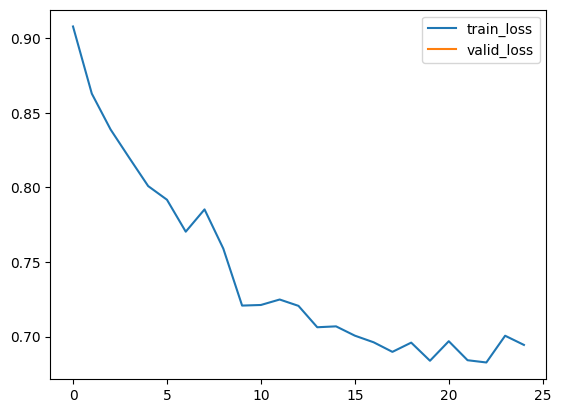

In [8]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

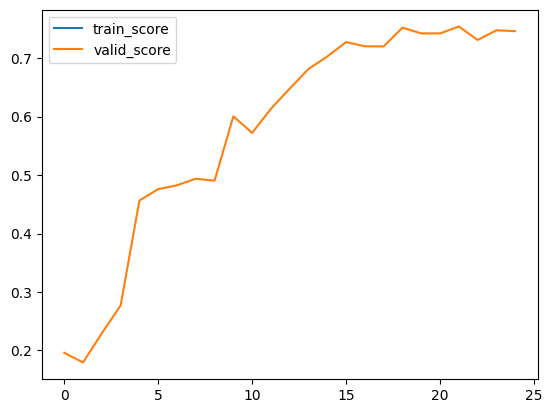

In [9]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [10]:
random.random()

0.55491014462897